# Horizontal Federated Learning for Image Classification

>The following codes are demos only. It's **NOT for production** due to system security concerns, please **DO NOT** use it directly in production.

In this tutorial, we will use the image classification task to show how to complete the horizontal federated learning task in the `SecretFlow` framework.
The `SecretFlow` framework provides a user-friendly API that makes it easy to apply your Keras or PyTorch model to a federated learning scenario as a federated learning model.
In the following tutorial we will provide a step-by-step demonstration on how to transform your existing model into a federated model using `SecretFlow`, enabling you to perform federated multi-party modeling tasks.

## What is Federated Learning

The federated learning discussed here specifically refers to horizontal federated learning, which involves the collaboration of samples. This approach is suitable for scenarios where all participating parties operate in the same business domain but serve different customer groups. By combining samples from multiple parties, a joint model with improved overall performance or better generalization capability can be trained. For example, in the medical field, each hospital has its own unique patient group, and hospitals in different regions have little to no overlap in their patient populations. However, their diagnostic records (such as medical images and blood tests) are of the same type.

<img alt="federate_learning.png" src="resources/federate_learning.png" width="600">

Training process: 

1. Each participant downloads the latest model from the server.
2. Each participant trains the model using its local data and uploads encrypted gradient (or encrypted parameter) to the server. The server collects the encrypted gradients (or parameters) from all participants, performs secure aggregation, and updates the model parameters accordingly.
3. The server returns the updated model to each participant.
4. Each participant updates its local model and prepares for the next training round.

## Federated Learning on SecretFlow

In [1]:
%load_ext autoreload
%autoreload 2

Create three entities [Alice, Bob, Charlie] in the SecretFlow environment.
Alice, Bob and Charlie are the three PYUs, where Alice and Bob act as clients, and Charlie acts as the server.

In [2]:
import secretflow as sf

# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))

# In case you have a running secretflow runtime already.
sf.shutdown()

sf.init(['alice', 'bob', 'charlie'], address='local')
alice, bob, charlie = sf.PYU('alice'), sf.PYU('bob'), sf.PYU('charlie')

The version of SecretFlow: 1.5.0.dev20240304


2024-03-05 09:57:07,464	INFO worker.py:1724 -- Started a local Ray instance.


In [3]:
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

### Prepare Training Data

Alice and Bob each own half the data.

In [4]:
from secretflow_fl.utils.simulation.datasets_fl import load_mnist

(x_train, y_train), (x_test, y_test) = load_mnist(
    parts={alice: 0.15, bob: 0.85},
    normalized_x=True,
    categorical_y=True,
    is_torch=False,
)

`x_train`, `y_train`, `x_test`, `y_test` are all `FedNdarray`. Let's take a look at the data obtained from `FedNdarray`. `FedNdarray` is a virtual `Ndarray` built on a multi-party concept to protect data privacy.
The underlying data is stored separately by each participant, and operations on `FedNdarray` are performed locally by each participant on their own data. Neither the server nor other clients have access to the raw data.
For demonstration purposes, we will manually download the data to the driver.
**This data will be used later for comparison with a single-party model**.

In [5]:
import numpy as np
from secretflow.utils.simulation.datasets import dataset

mnist = np.load(dataset('mnist'), allow_pickle=True)
image = mnist['x_train']
label = mnist['y_train']

Let's grab some samples from the dataset and visualize them to see what the data looks like for both Alice and Bob.

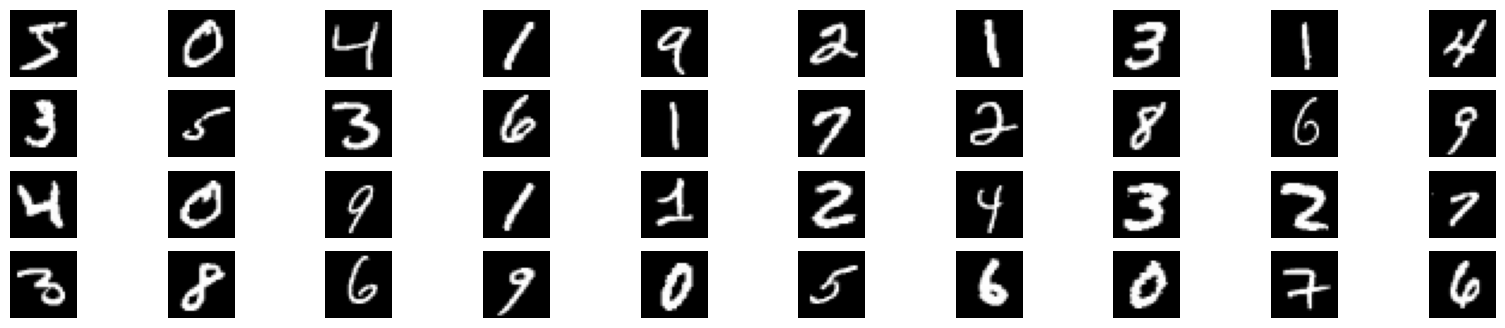

In [6]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(20, 4))
j = 0

for example in image[:40]:
    plt.subplot(4, 10, j + 1)
    plt.imshow(example, cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

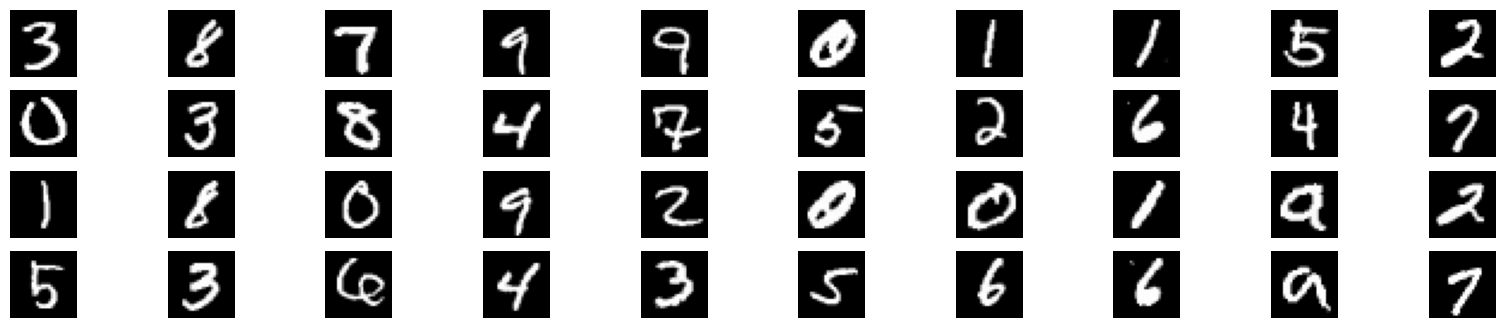

In [7]:
figure = plt.figure(figsize=(20, 4))
j = 0
for example in image[10000:10040]:
    plt.subplot(4, 10, j + 1)
    plt.imshow(example, cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1

It can be seen from the two examples above that Alice and Bob have the same data types and tasks, but the samples differ because they reach different user groups. Now, let's take the `FedNdarray` we obtained earlier and split it into training and testing sets for the subsequent training tasks.

### Define Model

In [8]:
def create_conv_model(input_shape, num_classes, name='model'):
    def create_model():
        from tensorflow import keras
        from tensorflow.keras import layers

        # Create model
        model = keras.Sequential(
            [
                keras.Input(shape=input_shape),
                layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
                layers.MaxPooling2D(pool_size=(2, 2)),
                layers.Flatten(),
                layers.Dropout(0.5),
                layers.Dense(num_classes, activation="softmax"),
            ]
        )
        # Compile model
        model.compile(
            loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]
        )
        return model

    return create_model

### Training FL Model

1. Import packages

In [9]:
from secretflow.security.aggregation import SPUAggregator, SecureAggregator
from secretflow_fl.ml.nn import FLModel

2. Define model

In [10]:
num_classes = 10
input_shape = (28, 28, 1)
model = create_conv_model(input_shape, num_classes)

3. Define the device list for the training participants, which includes the PYUs of each participant prepared earlier.

In [11]:
device_list = [alice, bob]

4. Define aggregator  
The SecretFlow framework provides a variety of aggregation schemes, including `SecureAggregator` and `PPUAggregator`, which can be used for secure aggregation. To learn more information about aggregation, see [Secure Aggregator](../developer/algorithm/secure_aggregation.ipynb).

In [12]:
secure_aggregator = SecureAggregator(charlie, [alice, bob])
spu_aggregator = SPUAggregator(spu)

INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.security.aggregation.secure_aggregator._Masker'> with party bob.


5. Define FL model

In [13]:
fed_model = FLModel(
    server=charlie,
    device_list=device_list,
    model=model,
    aggregator=secure_aggregator,
    strategy="fed_avg_w",
    backend="tensorflow",
)

2024-03-05 09:57:11.789182: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64:
2024-03-05 09:57:11.789267: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64:
2024-03-05 09:57:11.789274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2024-03-05 09:57:12.376683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'

6. Train FL model

In [14]:
history = fed_model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    sampler_method="batch",
    batch_size=128,
    aggregate_freq=1,
)

INFO:root:FL Train Params: {'x': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a66f50>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a66fe0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'y': FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a66c50>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a673d0>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), 'batch_size': 128, 'batch_sampling_rate': None, 'epochs': 10, 'verbose': 1, 'callbacks': None, 'validation_data': (FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a67820>, PYURuntime(bob): <secretflow.device.device.pyu.PYUObject object at 0x7feba8a67b50>}, partition_way=<PartitionWay.HORIZONTAL: 'horizontal'>), FedNdarray(partitions={PYURuntime(alice): <secretflow.device.device.pyu.PYUObject object at 0x7fe

(pid=488924) 2024-03-05 09:57:13.856657: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64:
(pid=488924) 2024-03-05 09:57:13.856750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11/lib64:
(pid=488924) 2024-03-05 09:57:13.856759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
(pid=488924) 2024-03-05 09:57:14.268949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] fail

Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 1/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 2/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 3/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 4/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 5/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 6/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 7/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 8/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 9/10


Train Processing: :   0%|          | 0/71 [00:00<?, ?it/s]

Epoch 10/10


Train Processing: :  99%|█████████▊| 70/71 [00:10<00:00,  6.97it/s, {'loss': 0.07390674, 'accuracy': 0.97742856, 'val_loss': 0.050366048, 'val_accuracy': 0.9832}]


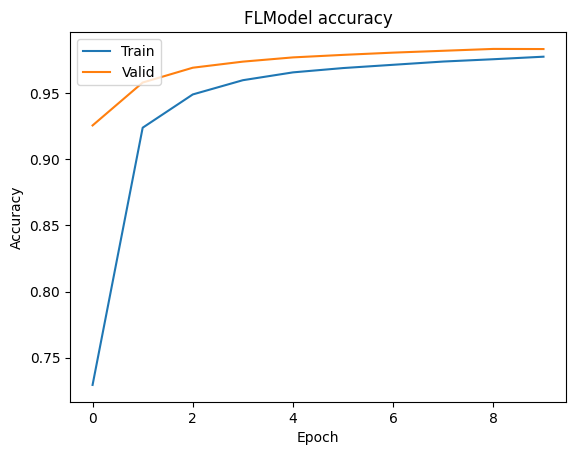

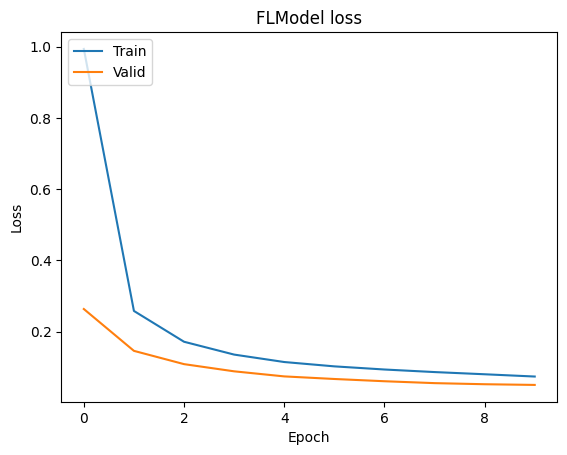

In [15]:
# Draw accuracy values for training & validation
plt.plot(history["global_history"]['accuracy'])
plt.plot(history["global_history"]['val_accuracy'])
plt.title('FLModel accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

# Draw loss for training & validation
plt.plot(history["global_history"]['loss'])
plt.plot(history["global_history"]['val_loss'])
plt.title('FLModel loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

In [16]:
global_metric = fed_model.evaluate(x_test, y_test, batch_size=128)
print(global_metric)

([Mean(name='val_loss', total=503.6605, count=10000.0), Mean(name='val_accuracy', total=9832.0, count=10000.0)], {'alice': [Mean(name='val_loss', total=101.31542, count=1500.0), Mean(name='val_accuracy', total=1463.0, count=1500.0)], 'bob': [Mean(name='val_loss', total=402.34506, count=8500.0), Mean(name='val_accuracy', total=8369.0, count=8500.0)]})


### Contrast experiment to local training

#### Model
The model structure is consistent with the fl model above.


#### Data
Similarly, the data used is the MNIST dataset. For the single-party model, we only used the horizontally segmented data from `Alice`, with a total of 20,000 samples.

In [17]:
from tensorflow import keras
from tensorflow.keras import layers


def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    # Compile model
    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"]
    )
    return model


single_model = create_model()

In [18]:
mnist.files

['x_test', 'x_train', 'y_train', 'y_test']

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

alice_x = image[:10000]
alice_y = label[:10000]
alice_y = OneHotEncoder(sparse_output=False).fit_transform(alice_y.reshape(-1, 1))

random_seed = 1234
alice_X_train, alice_X_test, alice_y_train, alice_y_test = train_test_split(
    alice_x, alice_y, test_size=0.1, random_state=random_seed
)

In [20]:
single_model.fit(
    alice_X_train,
    alice_y_train,
    validation_data=(alice_X_test, alice_y_test),
    batch_size=128,
    epochs=10,
)

Epoch 1/10
13/71 [====>.........................] - ETA: 0s - loss: 21.6627 - accuracy: 0.2981

71/71 [==============================] - 1s 10ms/step - loss: 5.2871 - accuracy: 0.6010 - val_loss: 0.4098 - val_accuracy: 0.8790
Epoch 2/10
71/71 [==============================] - 1s 9ms/step - loss: 0.6213 - accuracy: 0.8232 - val_loss: 0.2889 - val_accuracy: 0.9150
Epoch 3/10
71/71 [==============================] - 1s 9ms/step - loss: 0.4237 - accuracy: 0.8791 - val_loss: 0.2061 - val_accuracy: 0.9370
Epoch 4/10
71/71 [==============================] - 1s 8ms/step - loss: 0.2990 - accuracy: 0.9128 - val_loss: 0.1734 - val_accuracy: 0.9510
Epoch 5/10
71/71 [==============================] - 1s 8ms/step - loss: 0.2565 - accuracy: 0.9256 - val_loss: 0.1437 - val_accuracy: 0.9560
Epoch 6/10
71/71 [==============================] - 1s 9ms/step - loss: 0.2122 - accuracy: 0.9352 - val_loss: 0.1215 - val_accuracy: 0.9630
Epoch 7/10
71/71 [==============================] - 1s 8ms/step - loss: 0.1753 - accuracy: 0.9450 - val_loss: 0.1282 - val_accuracy: 0.9620
Epoch 8/10
71/71 [============

The two experiments above simulate a typical training problem in a horizontal federated learning scenario. Alice and Bob each have the same type of data, but each party only has a portion of the samples. However, their training objectives are the same. If Alice trains the model using only her own data, she achieves an accuracy of 0.969. But if Bob's data is combined, a model with an accuracy close to 0.983 can be obtained. Moreover, the model trained with data from multiple parties exhibits better generalization performance.

## Summary
* This tutorial introduces what federated learning is and how to perform horizontal federated learning in `SecretFlow`.  
* As shown in the experimental data, horizontal federated learning can improve model performance by expanding the sample size and combining multi-party training.
* This tutorial demonstrates using a SecureAggregator, and SecretFlow provides various aggregation schemes. For more infomation, see [Secure Aggregation](../developer/algorithm/secure_aggregation.ipynb).
* Next, you might want to try using different datasets. You’ll need to perform vertical data splitting first, and then follow the process outlined in this tutorial.
